In [1]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-2.csv
/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-1.csv
/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-5.csv
/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-3.csv
/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-4.csv


In this project, I will be creating a model that predicts how neighborhood determines real estate prices in Argentina

In [2]:
# The first thing to do is to import my data by creating a path through a function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Extract `neighborhood` 
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns = "place_with_parent_names", inplace=True)
    
    return df

Note that I am now dealing with a non-numerical data `neighborhood`

Due to the fact that I have many CV files, I will use use `glob` to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. Assign this list to the variable name files.

In [3]:
files = glob("/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-*csv")
files

['/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-2.csv',
 '/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-1.csv',
 '/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-5.csv',
 '/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-3.csv',
 '/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-4.csv']

In [4]:
# Check my work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

Next, I will have to read through every `CSV` file and  use `for` loop by creating a list called `frames` by using my `wrangle` function

In [5]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [6]:
len(frames)

5

In [7]:
frames[0].head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
2,sell,apartment,215000.0,USD,3259916.00,215000.00,40.0,35.0,5375.000000,6142.857143,NaN,1.0,3500.0,http://recoleta.properati.com.ar/12j4v_venta_d...,-34.588993,-58.400133,Recoleta
9,sell,apartment,341550.0,USD,5178717.72,341550.00,NaN,90.0,NaN,3795.000000,8.0,2.0,NaN,http://recoleta.properati.com.ar/100t0_venta_d...,-34.588044,-58.398066,Recoleta
12,sell,apartment,1386000.0,ARS,1382153.13,91156.62,39.0,33.0,2337.349231,42000.000000,NaN,NaN,NaN,http://monserrat.properati.com.ar/t05l_venta_d...,-34.623320,-58.397461,Monserrat
13,sell,apartment,105000.0,USD,1592052.00,105000.00,NaN,33.0,NaN,3181.818182,1.0,1.0,NaN,http://belgrano.properati.com.ar/zsd5_venta_de...,-34.553897,-58.451939,Belgrano
17,sell,apartment,89681.0,USD,1359779.19,89681.00,46.0,39.0,1949.586957,2299.512821,NaN,1.0,1500.0,http://villa-del-parque.properati.com.ar/12q2f...,-34.628813,-58.472230,Villa del Parque


In [8]:
# Check my work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

I need to then use `concatenate` to combine the `CSVs`

In [9]:
# Combining all of my dataframes using pandas
df = pd.concat(frames, ignore_index=True)
df.head()
df.shape

(6582, 17)

In [10]:
# Check my work
assert len(df) == 6582, f"`df` is the wrong size: {len(df)}."

The next step is to `Explore` my data

Remember, I need to modify my `neighborhood` feature. So I will go back to my `wrangle` function

Create your feature matrix X_train and target vector y_train. X_train should contain one feature: "neighborhood". Your target is "price_aprox_usd"

In [11]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [12]:
# Check your work
assert X_train.shape == (6582, 1), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

`Build Model`

I will start with the `baseline`

In [13]:
# I will start with the baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", "Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: Baseline MAE: 44860.10834274133


`Iterate`

I will have to encode my `neighborhood` to make it numerical and I will use `OneHotEncoder`

 First, instantiate a OneHotEncoder named ohe. Make sure to set the use_cat_names argument to True. Next, fit your transformer to the feature matrix X_train. Finally, use your encoder to transform the feature matrix X_train, and assign the transformed data to the variable XT_train.

In [14]:
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)

# Fit
ohe.fit(X_train)

# Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train

(6582, 57)


,neighborhood_Recoleta,neighborhood_Monserrat,neighborhood_Belgrano,neighborhood_Villa del Parque,neighborhood_Villa Pueyrredón,neighborhood_Almagro,neighborhood_Palermo,neighborhood_,neighborhood_Tribunales,neighborhood_Balvanera,...,neighborhood_Velez Sarsfield,neighborhood_Monte Castro,neighborhood_Las Cañitas,neighborhood_Constitución,neighborhood_Parque Avellaneda,neighborhood_Villa Soldati,neighborhood_Versalles,neighborhood_Pompeya,neighborhood_Villa Real,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6577,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6580,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Check your work
assert XT_train.shape == (6582, 57), f"`XT_train` is the wrong shape: {XT_train.shape}"

Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `Ridge` predictor. Then fit your model to the training data.

In [16]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    # Ridge will help in sorting the `Curse of Dimensionality`
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [17]:
# Check your work
check_is_fitted(model[-1])

`Evaluate`

First, create a list of predictions for the observations in your feature matrix X_train. Name this list y_pred_training. Then calculate the training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train.

In [18]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


`Communicate Results`

Extract the intercept and coefficients for your model.

In [19]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[ 72740.78075637 -20292.59601283  46954.20800905 -12595.50084744
  -8093.45014804]


In [20]:
# Check my work
assert isinstance(
    intercept, float
), f"`intercept` should be a `float`, not {type(intercept)}."
assert isinstance(
    coefficients, np.ndarray
), f"`coefficients` should be a `float`, not {type(coefficients)}."
assert coefficients.shape == (
    57,
), f"`coefficients` is wrong shape: {coefficients.shape}."

 Extract the feature names of your encoded data from the `OneHotEncoder` in your model.

In [21]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Recoleta' 'neighborhood_Monserrat' 'neighborhood_Belgrano'
 'neighborhood_Villa del Parque' 'neighborhood_Villa Pueyrredón']


In [22]:
# Check my work
assert isinstance(
    feature_names, np.ndarray
), f"`features` should be a `list`, not {type(feature_names)}."
assert len(feature_names) == len(
    coefficients
), "You should have the same number of features and coefficients."

Create a pandas Series named `feat_imp` where the index is your features and the values are your coefficients

In [23]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

neighborhood_Recoleta            72740.780756
neighborhood_Monserrat          -20292.596013
neighborhood_Belgrano            46954.208009
neighborhood_Villa del Parque   -12595.500847
neighborhood_Villa Pueyrredón    -8093.450148
dtype: float64

In [24]:
# Check your work
assert isinstance(
    feat_imp, pd.Series
), f"`feat_imp` should be a `float`, not {type(feat_imp)}."
assert feat_imp.shape == (57,), f"`feat_imp` is wrong shape: {feat_imp.shape}."
assert all(
    a == b for a, b in zip(sorted(feature_names), sorted(feat_imp.index))
), "The index of `feat_imp` should be identical to `features`."

Run the cell below to print the equation that your model has determined for predicting `apartment price` based on `longitude` and `latitude`

In [25]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (72740.78 * neighborhood_Recoleta)
+ (-20292.6 * neighborhood_Monserrat)
+ (46954.21 * neighborhood_Belgrano)
+ (-12595.5 * neighborhood_Villa del Parque)
+ (-8093.45 * neighborhood_Villa Pueyrredón)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (-19370.74 * neighborhood_)
+ (-7818.09 * neighborhood_Tribunales)
+ (-11172.55 * neighborhood_Balvanera)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-3230.37 * neighborhood_Once)
+ (5638.47 * neighborhood_San Telmo)
+ (-48669.35 * neighborhood_Villa Lugano)
+ (12223.11 * neighborhood_Coghlan)
+ (-4618.66 * neighborhood_Barracas)
+ (12671.71 * neighborhood_Villa Urquiza)
+ (4330.55 * neighborhood_Abasto)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-19843.92 * neighborhood_Villa Santa Rita)
+ (38436.33 * neighborhood_Colegiales)
+ (-7108.23 * neighborhood_Paternal)
+ (9252.89 * neighborhood_Caballito)
+ (-7678.62 * neighborhood_Parque Chacabuco)
+ (27042.61 * neighborhood_Retiro)
+ (3860.58 * neighbo

Create a horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value.

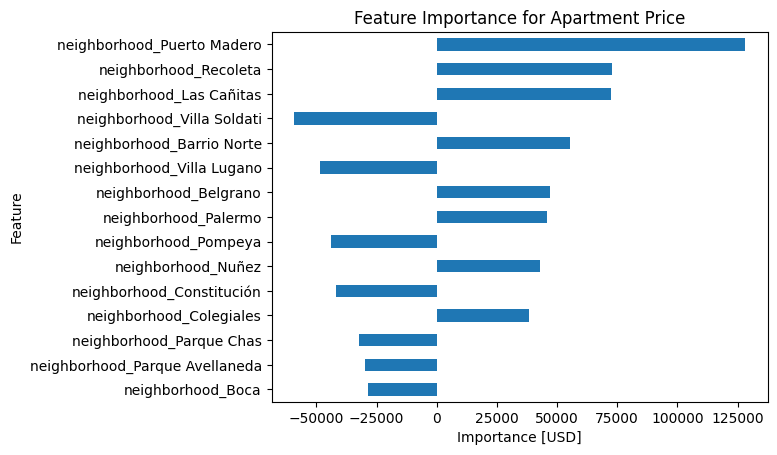

In [26]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price");